# Mod 5 Project: Classifying Loan Default
### Dataset: LendingClub 2007-11

In [4]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
warnings.filterwarnings('ignore')


%matplotlib inline
plt.rcParams['figure.figsize'] = (16,9)

## EDA
#### Load CSV file and begin EDA

In [5]:
loan_df = pd.read_csXGBClassifier.csv', skiprows = 1, low_memory = False)
display(loan_df.head())

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42535 entries, 0 to 42534
Columns: 150 entries, id to settlement_term
dtypes: float64(120), object(30)
memory usage: 48.7+ MB


None

In [6]:
# drop any values with more than half missing
half_na = len(loan_df)/2
loan_df = loan_df.dropna(thresh = half_na, axis = 1)
loan_df = loan_df.drop(['url','desc'], axis = 1)


In [7]:
loan_df.shape

(42535, 57)

In [8]:
#Drop irrelevant columns
drops = ['id', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'sub_grade', 'emp_title', 'issue_d', 'zip_code', 
         'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
         'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
         'pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 
         'chargeoff_within_12_mths', 'pub_rec_bankruptcies', 'tax_liens',
         'hardship_flag', 'debt_settlement_flag', 'delinq_amnt']
loan_df = loan_df.drop(columns = drops, axis = 1)

In [9]:
# Average fico score (unique to entry)
loan_df['avg_fico'] = (loan_df['fico_range_high'] + loan_df['fico_range_low'])/2

In [10]:
loan_df = loan_df.drop(columns = ['fico_range_low', 'fico_range_high', 'last_fico_range_low', 'last_fico_range_high'], axis = 1)

In [11]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42535 entries, 0 to 42534
Data columns (total 24 columns):
loan_amnt              42532 non-null float64
term                   42532 non-null object
installment            42532 non-null float64
grade                  42532 non-null object
emp_length             41420 non-null object
home_ownership         42532 non-null object
annual_inc             42528 non-null float64
verification_status    42532 non-null object
loan_status            42532 non-null object
purpose                42532 non-null object
title                  42519 non-null object
addr_state             42532 non-null object
dti                    42532 non-null float64
delinq_2yrs            42503 non-null float64
earliest_cr_line       42503 non-null object
inq_last_6mths         42503 non-null float64
open_acc               42503 non-null float64
pub_rec                42503 non-null float64
revol_bal              42532 non-null float64
revol_util             4244

In [12]:
loan_df.loan_status.value_counts()

Fully Paid                                             34113
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

In [13]:
#Label Binarize loan status target to 1 = paid, 0 = charged off 
loan_df = loan_df[(loan_df.loan_status == 'Fully Paid') | (loan_df.loan_status == 'Charged Off')] 
loan_status_dict = {"loan_status" : {"Fully Paid":1, "Charged Off":0}}
loan_df = loan_df.replace(loan_status_dict);

In [14]:
loan_df.loan_status.value_counts()

1    34113
0     5670
Name: loan_status, dtype: int64

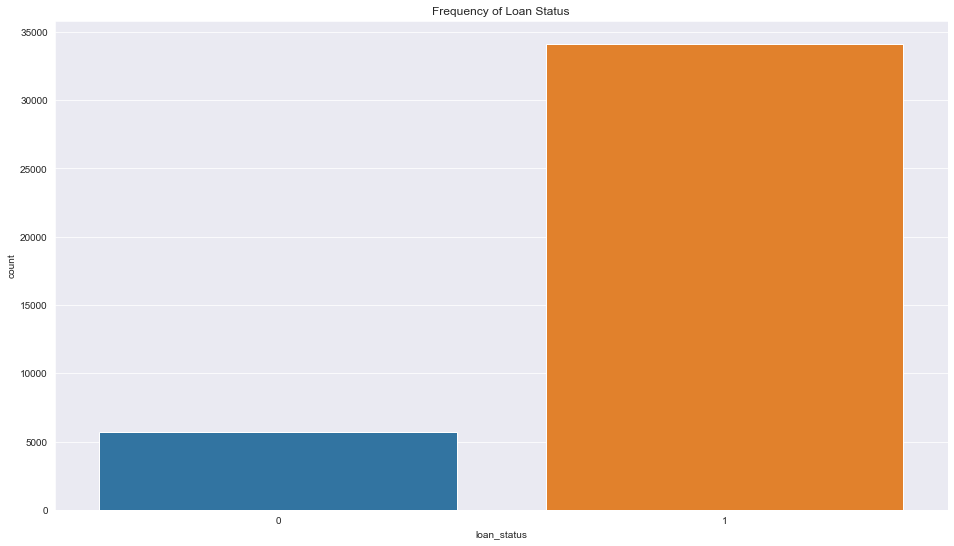

In [15]:

fig = plt.figure(figsize = (16,9))
sns.set_style('darkgrid')
sns.countplot(loan_df.loan_status).set_title('Frequency of Loan Status')
plt.show()

In [16]:
print(f"Percentage of borrowers with loans fully paid: {round(sum(loan_df.loan_status == 1)/len(loan_df.loan_status) * 100,2)} %")

Percentage of borrowers with loans fully paid: 85.75 %


### Handle Missing Data/Categoricals

In [17]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39783 entries, 0 to 39782
Data columns (total 24 columns):
loan_amnt              39783 non-null float64
term                   39783 non-null object
installment            39783 non-null float64
grade                  39783 non-null object
emp_length             38705 non-null object
home_ownership         39783 non-null object
annual_inc             39783 non-null float64
verification_status    39783 non-null object
loan_status            39783 non-null int64
purpose                39783 non-null object
title                  39772 non-null object
addr_state             39783 non-null object
dti                    39783 non-null float64
delinq_2yrs            39783 non-null float64
earliest_cr_line       39783 non-null object
inq_last_6mths         39783 non-null float64
open_acc               39783 non-null float64
pub_rec                39783 non-null float64
revol_bal              39783 non-null float64
revol_util             39733

In [18]:
loan_df = loan_df.dropna()

In [19]:
loan_df.dtypes.value_counts()

float64    12
object     11
int64       1
dtype: int64

In [20]:
loan_df.revol_util = loan_df.revol_util.str.rstrip('%').astype('float')
loan_df_objects = loan_df.select_dtypes(include = ['object'])
print(loan_df_objects.iloc[0])

term                     36 months
grade                            B
emp_length               10+ years
home_ownership                RENT
verification_status       Verified
purpose                credit_card
title                     Computer
addr_state                      AZ
earliest_cr_line          Jan-1985
last_credit_pull_d        Dec-2019
Name: 0, dtype: object


In [21]:
#Drop addr_state (too many values)
drops = ['last_credit_pull_d', 'addr_state', 'title', 'earliest_cr_line']
loan_df = loan_df.drop(drops, axis = 1)

In [22]:
display(loan_df.emp_length.value_counts())
display(loan_df.grade.value_counts())

10+ years    8896
< 1 year     4576
2 years      4389
3 years      4093
4 years      3435
5 years      3279
1 year       3239
6 years      2227
7 years      1771
8 years      1483
9 years      1258
Name: emp_length, dtype: int64

B    11694
A     9692
C     7924
D     5194
E     2799
F     1028
G      315
Name: grade, dtype: int64

In [23]:
#Create mapping dictionary for ordinal categorical values
ordinal_dict = {"emp_length" : {
                                "10+ years": 10,
                                "9 years": 9,
                                "8 years": 8,
                                "7 years": 7,
                                "6 years": 6,
                                "5 years": 5,
                                "4 years": 4,
                                "3 years": 3,
                                "2 years": 2,
                                "1 year": 1,
                                "< 1 year": 0,
                                "n/a": 0},
                "grade" : {
                    "A": 1,
                    "B": 2,
                    "C": 3,
                    "D": 4,
                    "E": 5,
                    "F": 6,
                    "G": 7
                }}

loan_df = loan_df.replace(ordinal_dict)


In [24]:
#Standard Scale numeric values
from sklearn.preprocessing import StandardScaler
numerics = list(loan_df.select_dtypes(include = ['int64', 'float64']))
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(loan_df[numerics]), columns = numerics)

In [25]:
# Create dummy variables for nominal values
nominals = ['home_ownership', 'verification_status', 'purpose', 'term']
dummy_loan_df = pd.get_dummies(loan_df[nominals], drop_first = True)



In [27]:
loan_df_clean = pd.concat([scaled_df, dummy_loan_df], axis = 1)

In [28]:
loan_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39778 entries, 0 to 39782
Data columns (total 35 columns):
loan_amnt                              38646 non-null float64
installment                            38646 non-null float64
grade                                  38646 non-null float64
annual_inc                             38646 non-null float64
loan_status                            38646 non-null float64
dti                                    38646 non-null float64
delinq_2yrs                            38646 non-null float64
inq_last_6mths                         38646 non-null float64
open_acc                               38646 non-null float64
pub_rec                                38646 non-null float64
revol_bal                              38646 non-null float64
revol_util                             38646 non-null float64
total_acc                              38646 non-null float64
acc_now_delinq                         38646 non-null float64
avg_fico               

# Classification Modeling

### Train Test Split

In [55]:
X = loan_df.drop(columns = 'loan_status')
y = loan_df.loan_status

In [63]:
X_cat = X.select_dtypes(include='object')
X_num = X.select_dtypes(exclude='object')
X_num = X_num.join(pd.get_dummies(X_cat))
ss = StandardScaler()
X_num = pd.DataFrame(ss.fit_transform(X_num))

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size = .20, random_state = 33)

### SMOTE

In [59]:
X_train

,loan_amnt,installment,grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,avg_fico
3635,24000.0,750.97,1,115000.0,17.82,0.0,0.0,16.0,0.0,11765.0,47.6,34.0,0.0,737.0
11259,5000.0,168.45,3,43000.0,24.17,0.0,1.0,8.0,0.0,3228.0,21.8,23.0,0.0,682.0
14832,11200.0,353.51,1,87000.0,8.73,0.0,2.0,11.0,0.0,17274.0,47.6,23.0,0.0,737.0
23265,3000.0,97.31,2,93600.0,21.28,1.0,0.0,9.0,0.0,7584.0,75.1,18.0,0.0,682.0
38721,7500.0,235.03,1,60000.0,4.96,0.0,7.0,10.0,0.0,78935.0,26.2,34.0,0.0,777.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28248,3500.0,107.69,1,45000.0,13.41,0.0,1.0,21.0,0.0,5655.0,10.8,39.0,0.0,752.0
587,2400.0,80.51,2,59393.0,13.70,0.0,1.0,12.0,1.0,3265.0,44.1,18.0,0.0,682.0
39753,12000.0,401.37,4,75000.0,15.00,0.0,3.0,9.0,0.0,43039.0,93.4,24.0,0.0,682.0
2505,5500.0,193.26,3,32000.0,21.49,0.0,1.0,10.0,0.0,9424.0,88.9,14.0,0.0,667.0


In [67]:
from imblearn.over_sampling import SMOTE
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train)
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns = X_train.columns)
pd.Series(y_train_resampled).value_counts()

1    26608
0    26608
dtype: int64

## Random Forest

In [69]:
#Criterion: Gini Coefficient
classifier = DecisionTreeClassifier(random_state = 33)
classifier.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=33, splitter='best')

In [70]:
y_pred = classifier.predict(X_test)

In [71]:
acc = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy is: {round(acc,2)}%")

#Check predictions-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f"\nAUC is: {round(roc_auc, 2)}")

#Confusion Matrix
print('---------------------------')
print("\nConfusion Matrix:\n")
print(pd.crosstab(y_test, y_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))

Accuracy is: 74.41%

AUC is: 0.52
---------------------------

Confusion Matrix:

Predicted     0     1   All
True                       
0           219   896  1115
1          1082  5533  6615
All        1301  6429  7730


In [72]:
#Train DT Classifier (Criterion: Entropy)
classifier2 = DecisionTreeClassifier(random_state = 33, criterion = 'entropy')
classifier2.fit(X_train_resampled, y_train_resampled)
y_pred = classifier2.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy is: {round(acc,2)}%")

#Check predictions-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f"\nAUC is: {round(roc_auc, 2)}")

#Confusion Matrix
print('---------------------------')
print("\nConfusion Matrix:\n")
print(pd.crosstab(y_test, y_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))


Accuracy is: 75.56%

AUC is: 0.54
---------------------------

Confusion Matrix:

Predicted     0     1   All
True                       
0           252   863  1115
1          1026  5589  6615
All        1278  6452  7730


<Figure size 2160x2160 with 0 Axes>

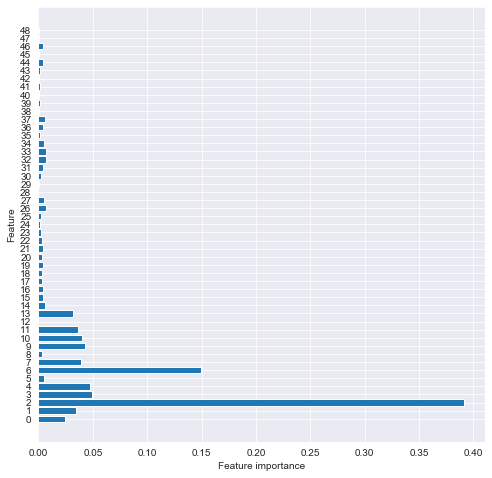

In [76]:
# Feature Importance (X_train)

classifier2.feature_importances_
def plot_feature_importances(model):
    plt.figure(figsize = (30,30))
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    

plot_feature_importances(classifier2)

In [77]:
pred = classifier2.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 252  863]
 [1026 5589]]
              precision    recall  f1-score   support

           0       0.20      0.23      0.21      1115
           1       0.87      0.84      0.86      6615

    accuracy                           0.76      7730
   macro avg       0.53      0.54      0.53      7730
weighted avg       0.77      0.76      0.76      7730



In [78]:
forest = RandomForestClassifier(n_estimators = 100, max_depth = 6)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [79]:
forest.score(X_train_resampled, y_train_resampled)

0.7703510222489477

In [80]:
forest.score(X_test, y_test)

0.7064683053040104

<Figure size 2160x2160 with 0 Axes>

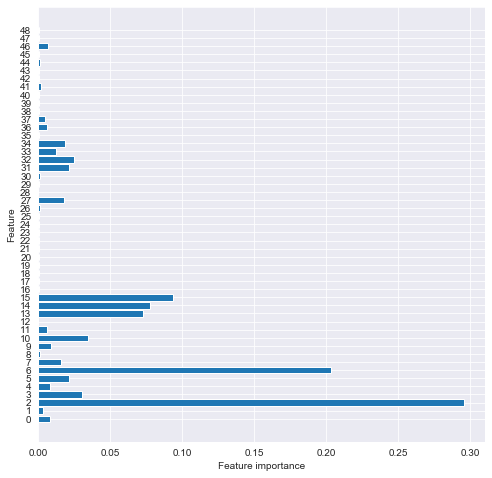

In [81]:
plot_feature_importances(forest)

### Hyperparameter Selection / Grid Search

In [85]:

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators':[30,100,300],
    'min_samples_split':[2,4,6],
    'min_samples_leaf':[2,4,6]
}

In [83]:
gs = GridSearchCV(forest, param_grid, cv = 5)
gs.fit(X_train_resampled, y_train_resampled)
gs.score(X_test, y_test)
gs.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}

In [86]:
classifier3 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', min_samples_leaf = 2, min_samples_split = 4)
classifier3.fit(X_train_resampled, y_train_resampled)
classifier3.predict(X_test)
print(f"Train Accuracy Score: {classifier3.score(X_train_resampled, y_train_resampled)}")
print(f"Test Accuracy Score: {classifier3.score(X_test, y_test)}")
print(f"\nAUC is: {round(roc_auc, 2)}")

Train Accuracy Score: 0.9951706253758268
Test Accuracy Score: 0.8443725743855109

AUC is: 0.54


## SVM

In [88]:
from sklearn.svm import SVC
svclassifier = SVC(kernel = 'linear')
svclassifier.fit(X_train_resampled, y_train_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [89]:
y_pred = svclassifier.predict(X_test)

In [90]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[ 706  409]
 [2438 4177]]
              precision    recall  f1-score   support

           0       0.22      0.63      0.33      1115
           1       0.91      0.63      0.75      6615

    accuracy                           0.63      7730
   macro avg       0.57      0.63      0.54      7730
weighted avg       0.81      0.63      0.69      7730

The accuracy score is 0.6316946959896507


## XGBoost

In [91]:
from xgboost import XGBClassifier

In [92]:
clf = XGBClassifier()
clf.fit(X_train_resampled, y_train_resampled)

training_preds = clf.predict(X_train_resampled)
test_preds = clf.predict(X_test)

training_accuracy = accuracy_score(y_train_resampled, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48'] ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48']
expected f34, f17, f40, f37, f31, f28, f10, f16, f19, f8, f5, f48, f29, f2, f4, f20, f21, f22, f42, f45, f32, f46, f30, f14, f33, f6, f43, f9, f18, f3, f36, f1, f25, f0, f24, f7, f38, f41, f44, f47, f23, f27, f39, f26, f15, f13, f35, f12, f11 in input data
training data did not have the following fields: 8, 27, 10, 38, 37, 36, 39, 45, 33, 15, 34, 23, 4, 19, 0, 2, 25, 9, 17, 30, 14, 20, 29, 35, 31, 46, 12, 18, 47, 41, 24, 13, 43, 42, 40, 21, 3, 5, 1, 32, 28, 22, 6, 16, 48, 7, 11, 44, 26

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [ ]:
grid_clf = GridSearchCV(clf, param_grid, scoring = 'accuracy', cv = None, n_jobs = 1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_resampled)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train_resampled, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_resampled, y_train_resampled)
y_pred_class = knn.predict(X_test)

from sklearn import metrics
print('Accuracy:' + str(metrics.accuracy_score(y_test, y_pred_class)))
print('F1: ' + str(metrics.f1_score(y_test, y_pred_class)))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_class)
classes = ['Defaulted', 'Paid Off']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_resampled, y_train_resampled)
y_pred_class = knn.predict(X_test)
print('Accuracy:' + str(metrics.accuracy_score(y_test, y_pred_class)))
print('F1: ' + str(metrics.f1_score(y_test, y_pred_class)))
print(classification_report(y_test, y_pred_class))